In [1]:
%run setup_workspace.ipynb # loads data

In [2]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, SimpleRNN
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator
import pandas as pd
from datetime import date
from keras import backend as K 
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
data = daily_energy_consumption
# data = pd.merge(data, daily_wheather_data, on='ds')
data.ds.min(), data.ds.max()

(datetime.date(2011, 1, 1), datetime.date(2018, 8, 3))

# Creating a Recurrent Neural Network model

## 1. Train-test-split

In [4]:
split_date = date(2015,1,1)
split_date2 = date(2015,12,29)
min_date = date(2010,1,1)
max_date = date(2017,1,1)

train = data[data.ds < split_date]
if min_date is not None:
    train = train[train['ds'] > min_date]

valid = data[(data.ds > split_date) & (data.ds < split_date2)]

test = data[data.ds > split_date2]
if max_date is not None:
    test = test[test['ds'] < max_date]

## Visualization

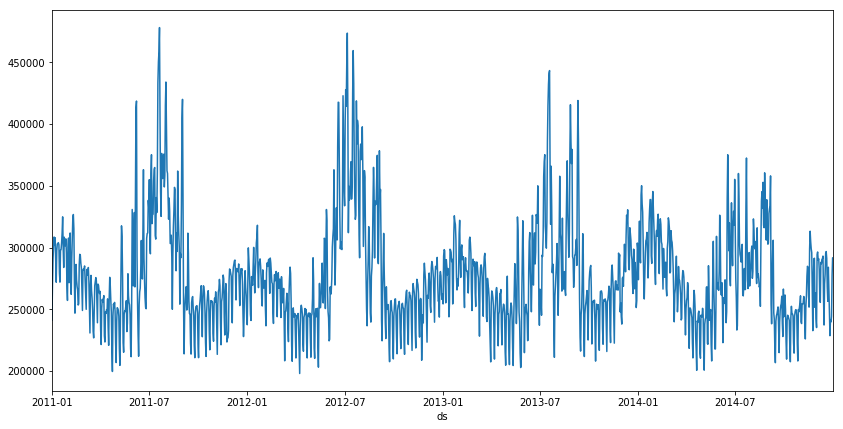

In [5]:
train.set_index('ds').y.plot(figsize=(14,7))

In [6]:
input_len = 3
rtrain = train.y.values.reshape(len(train.y.values),1)
rtest = test.y.values.reshape(len(test.y.values),1)
rvalid = valid.y.values.reshape(len(valid.y.values),1)
train_generator = TimeseriesGenerator(rtrain, rtrain, length=input_len, batch_size=1)
test_generator = TimeseriesGenerator(rtest, rtest, length=input_len, batch_size=1)
valid_generator = TimeseriesGenerator(rvalid, rvalid, length=input_len, batch_size=1)

## 2. Model training

In [7]:
model = Sequential()
model.add(SimpleRNN(100, activation='elu', input_shape=(input_len, 1)))
model.add(Dense(50))
# model.add(Dropout(rate=0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 100)               10200     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 15,301
Trainable params: 15,301
Non-trainable params: 0
_________________________________________________________________


In [8]:
%%time
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

history =  model.fit_generator(train_generator, steps_per_epoch=5, epochs=150, verbose=0, 
                               callbacks=[earlyStopping], 
                               validation_data=valid_generator)

Instructions for updating:
Use tf.cast instead.
CPU times: user 14.1 s, sys: 2.2 s, total: 16.3 s
Wall time: 10.9 s


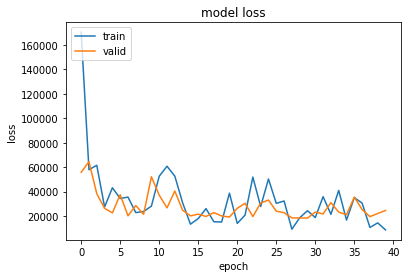

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

## 3. Forecast

In [10]:
prediction = model.predict_generator(test_generator)

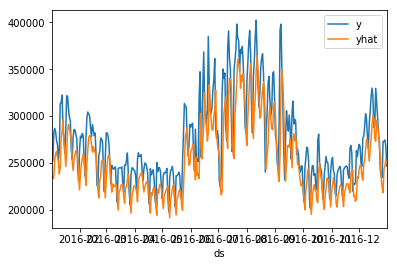

In [11]:
tmp = test.iloc[input_len:,:].copy().set_index('ds')
tmp['yhat'] = prediction
tmp[['y','yhat']].plot()

## 4. Evaluation

In [12]:
error = mean_absolute_percentage_error(test.y[input_len:].values, prediction)
print('MAPE:%0.2f%%'%error)

MAPE:16.95%


## 5. Train and evaluate several times

In [13]:
# mape_results = []
# for i in range(0,30):
#     K.clear_session()
#     model = Sequential()
#     model.add(SimpleRNN(50, activation='elu', input_shape=(input_len, 1)))
#     model.add(Dense(1))
#     model.compile(optimizer='adadelta', loss='mae')
    
#     earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

#     history =  model.fit_generator(train_generator, steps_per_epoch=5, epochs=150, verbose=0, 
#                                callbacks=[earlyStopping], 
#                                validation_data=valid_generator)
    
#     prediction = model.predict_generator(test_generator)
    
#     error = mean_absolute_percentage_error(test.y[input_len:].values, prediction)
#     print('MAPE:%0.2f%%'%error)
#     mape_results.append(error)

# print(np.mean(mape_results))